## Basics


In [3]:
# imports
import numpy as np

import commstools.plotting as plotting
from commstools import get_backend, set_backend
from commstools.backend import ensure_on_backend
from commstools.filtering import rrc_taps
from commstools.sequences import prbs
# from commstools.waveforms import ook

set_backend("gpu")


In [4]:
backend = get_backend()

backend.name


'gpu'

Let's start with generating a bit sequence which will represent the data we want to transmit.

In [2]:
# Generate a Pseudo-Random Binary Sequence (PRBS)
bits = prbs(length=2**20, order=31, seed=0x30F1CA55)

print("First Generated 20 bits:", bits[:20])
print("Mean value: ", bits.mean())


First Generated 20 bits: [1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0]
Mean value:  0.5333318710327148


Let's define base system parameters and map the bits to an OOK signal.

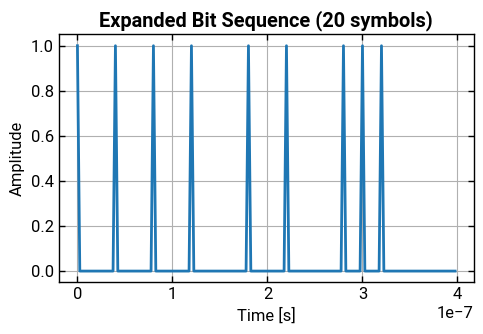

In [ ]:
# Define system parameters
symbol_rate = 50e6
sampling_rate = 400e6
sps = int(sampling_rate / symbol_rate)
rrc_rolloff = 0.3

sig_impulse = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="none")

sig_impulse.plot_signal(
    num_symbols=20, show=True, title="Expanded Bit Sequence (20 symbols)"
)


Now, let's pulse shape the signal to get the actual waveform.

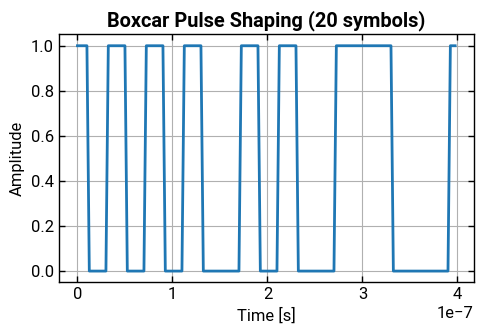

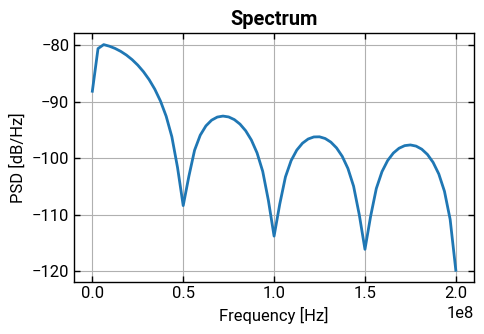

In [ ]:
# Boxcar (rectangular) pulse shaping
sig_boxcar = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="boxcar")

sig_boxcar.plot_signal(
    num_symbols=20, show=True, title="Boxcar Pulse Shaping (20 symbols)"
)
sig_boxcar.plot_psd(show=True, title="Spectrum")


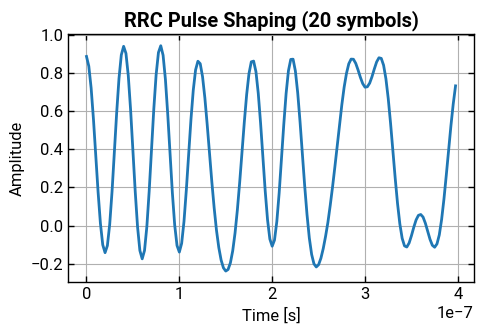

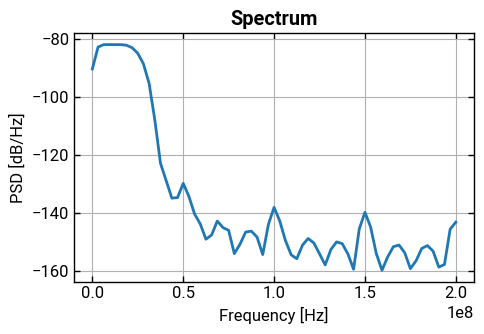

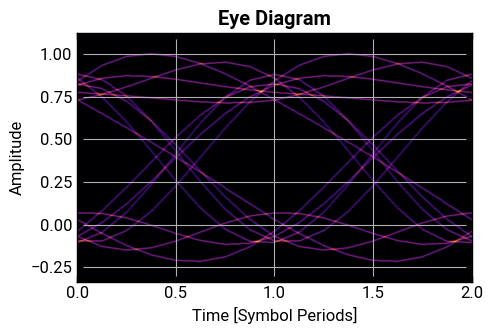

In [ ]:
# RRC pulse shaping
sig_rrc = ook(
    bits,
    sampling_rate=sampling_rate,
    sps=sps,
    pulse_shape="rrc",
    filter_span=18,
    rrc_rolloff=rrc_rolloff,
)

sig_rrc.plot_signal(num_symbols=20, show=True, title="RRC Pulse Shaping (20 symbols)")
sig_rrc.plot_psd(show=True, title="Spectrum")
sig_rrc.plot_eye(plot_type="hist", show=True, cmap="inferno")


Let's investigate the RRC filter we applied.

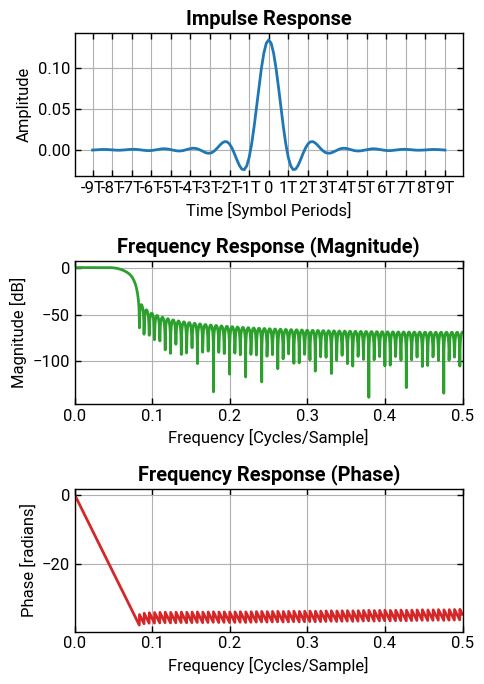

In [ ]:
# Create the same RRC filter
rrc_filter = rrc_taps(sps=sps, rolloff=rrc_rolloff, span=18)

# Plot the filter response
plotting.filter_response(rrc_filter, sps, show=True)


Let's add some noise to the signal for naive representation of distorted signal on the receiver.

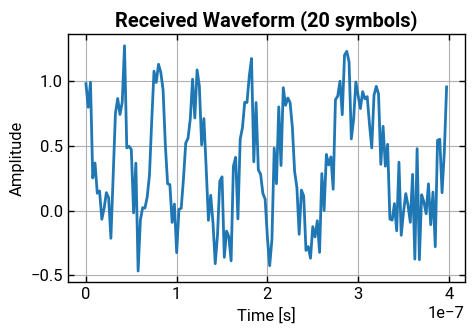

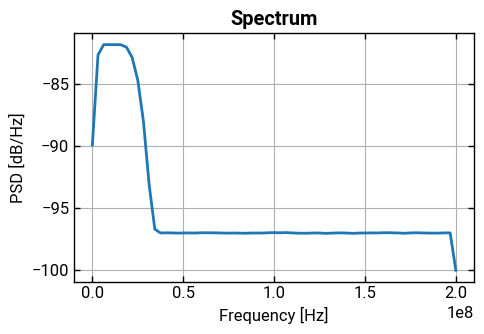

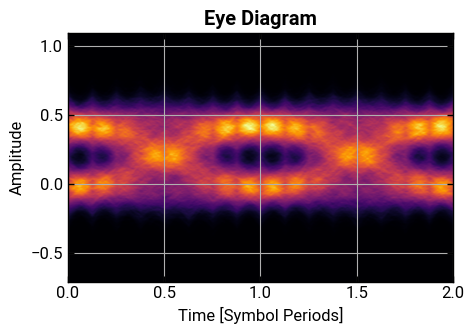

In [ ]:
noise = 0.2 * np.random.randn(*sig_rrc.samples.shape)

noise = ensure_on_backend(noise)
sig_rrc.samples = sig_rrc.samples + noise


sig_rrc.plot_signal(num_symbols=20, show=True, title="Received Waveform (20 symbols)")
sig_rrc.plot_psd(show=True, title="Spectrum")
sig_rrc.plot_eye(plot_type="hist", show=True, cmap="inferno")


Now we can check what happens on the receiver side.
As the pulse shape is RRC, we need to use a matched filter with the same RRC shape at the receiver.

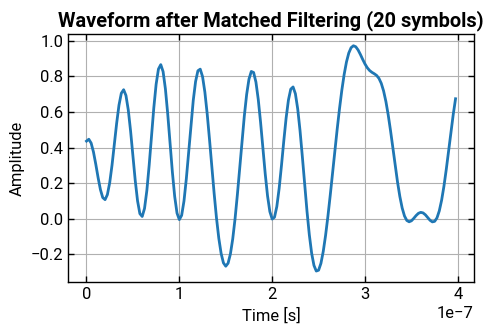

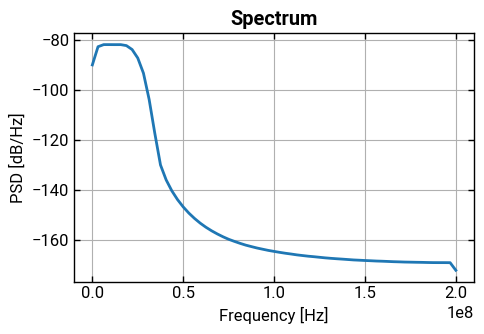

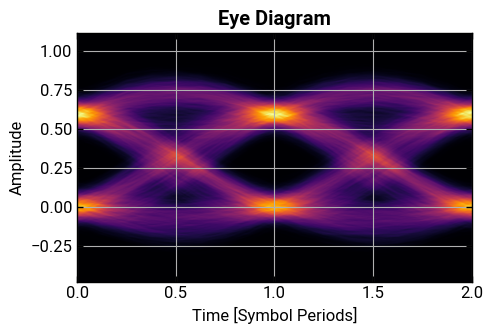

In [ ]:
sig_rrc.matched_filter(
    pulse_taps=rrc_filter, taps_normalization="unity_gain", normalize_output=False
)

sig_rrc.plot_signal(
    num_symbols=20, show=True, title="Waveform after Matched Filtering (20 symbols)"
)
sig_rrc.plot_psd(show=True, title="Spectrum")
sig_rrc.plot_eye(plot_type="hist", show=True, cmap="inferno")


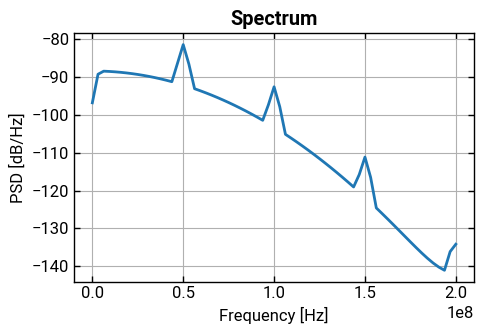

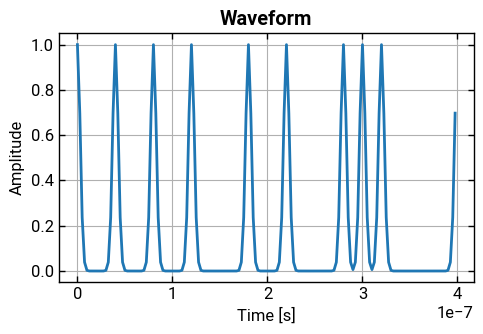

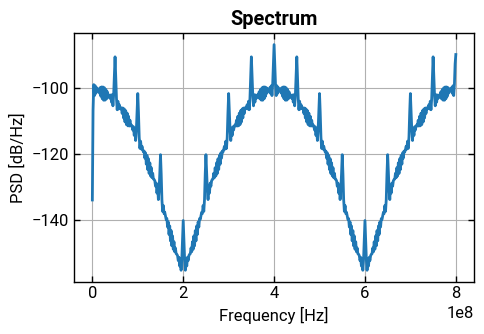

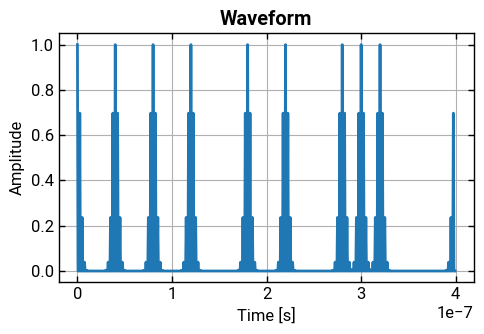

In [ ]:
from commstools.dsp.multirate import expand

sig_boxcar = ook(
    bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="gaussian", gaussian_bt=0.9
)


sig_orig = sig_boxcar

sig_orig.plot_psd(show=True)
sig_orig.plot_signal(show=True, num_symbols=20)

# expand boxcar signal and check spectre
bcs = sig_boxcar.samples
bcs = expand(bcs, 4)

sig_expanded = sig_orig
sig_expanded.samples = bcs
sig_expanded.sampling_rate *= 4

sig_expanded.plot_psd(show=True, nperseg=1024)
sig_expanded.plot_signal(show=True, num_symbols=20)


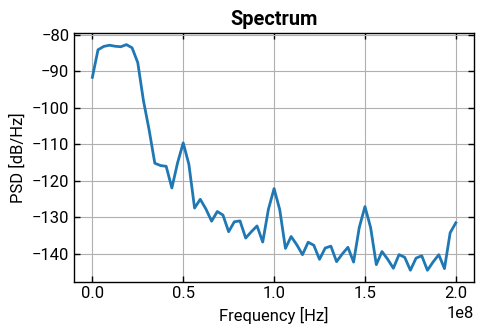

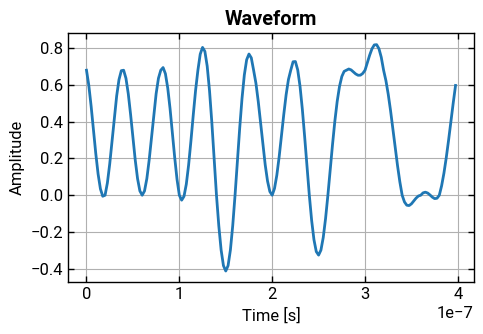

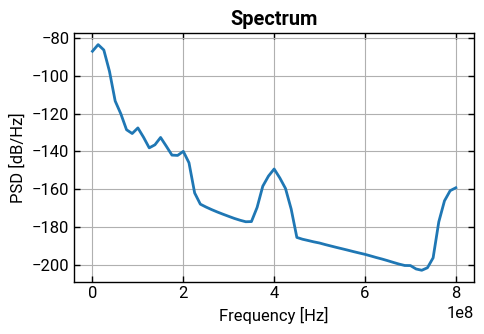

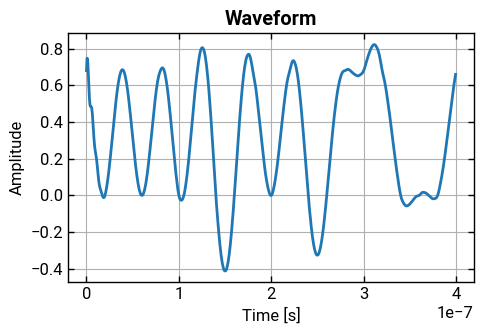

In [ ]:
# expand + anti-imaging filter
sig_boxcar = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="sinc")

sig_boxcar.plot_psd(show=True)
sig_boxcar.plot_signal(show=True, num_symbols=20)

sig_boxcar.upsample(4)

sig_boxcar.plot_psd(show=True, nperseg=128)
sig_boxcar.plot_signal(show=True, num_symbols=20)


In [ ]:
from commstools.dsp import gray_code, gray_constellation


/home/lokgar/commstools/.venv/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [ ]:
import numpy as np

code = gray_code(4)

bin_func = np.vectorize(np.binary_repr)
binary_array = bin_func(code, width=4)

print(binary_array)


['0000' '0001' '0011' '0010' '0110' '0111' '0101' '0100' '1100' '1101'
 '1111' '1110' '1010' '1011' '1001' '1000']


In [ ]:
print(const)


[-7.-7.j -7.-5.j -7.-1.j -7.-3.j -7.+7.j -7.+5.j -7.+1.j -7.+3.j -5.-7.j
 -5.-5.j -5.-1.j -5.-3.j -5.+7.j -5.+5.j -5.+1.j -5.+3.j -1.-7.j -1.-5.j
 -1.-1.j -1.-3.j -1.+7.j -1.+5.j -1.+1.j -1.+3.j -3.-7.j -3.-5.j -3.-1.j
 -3.-3.j -3.+7.j -3.+5.j -3.+1.j -3.+3.j  7.-7.j  7.-5.j  7.-1.j  7.-3.j
  7.+7.j  7.+5.j  7.+1.j  7.+3.j  5.-7.j  5.-5.j  5.-1.j  5.-3.j  5.+7.j
  5.+5.j  5.+1.j  5.+3.j  1.-7.j  1.-5.j  1.-1.j  1.-3.j  1.+7.j  1.+5.j
  1.+1.j  1.+3.j  3.-7.j  3.-5.j  3.-1.j  3.-3.j  3.+7.j  3.+5.j  3.+1.j
  3.+3.j]


/home/lokgar/commstools/.venv/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


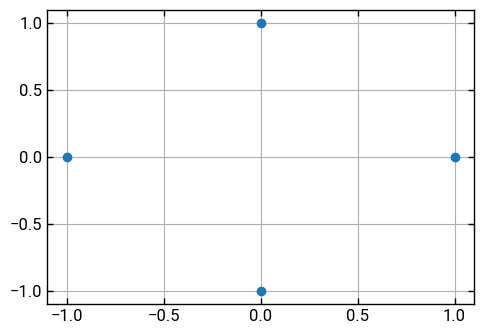

In [ ]:
from commstools.dsp import gray_code, gray_constellation


import matplotlib.pyplot as plt

const = gray_constellation(modulation="psk", order=4)

plt.plot(const.real, const.imag, marker="o", linestyle="")
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)


In [ ]:
const


array([ 1.+0.0000000e+00j, -1.+1.2246468e-16j])

[-1.-1.j -1.+1.j  1.-1.j  1.+1.j]


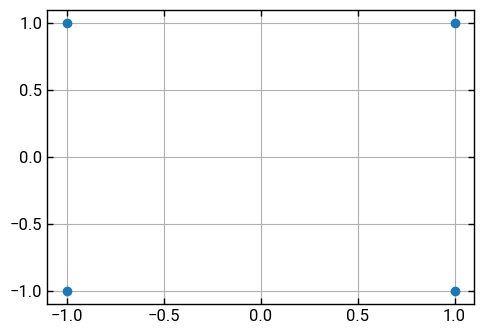

In [ ]:
import matplotlib.pyplot as plt

const = gray_constellation(modulation="qam", order=4)
print(const)

plt.plot(const.real, const.imag, marker="o", linestyle="")
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)


In [ ]:
import numpy as np

code = gray_code(3)


bin_func = np.vectorize(np.binary_repr)
binary_array = bin_func(code, width=4)

print(code)
print(binary_array)

const = gray_constellation(modulation="psk", order=2)

print(const)


[0 1 3 2 6 7 5 4]
['0000' '0001' '0011' '0010' '0110' '0111' '0101' '0100']
[-1.  1.]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from commstools.mapping import gray_code, gray_constellation


def plot_constellation(modulation, order):
    try:
        constellation = gray_constellation(modulation, order)
    except ValueError as e:
        print(f"Error: {e}")
        return

    # Handle real-only constellations (like ASK/BPSK) for plotting
    if np.isrealobj(constellation):
        real = constellation
        imag = np.zeros_like(real)
    else:
        real = constellation.real
        imag = constellation.imag

    plt.figure(figsize=(15, 15))
    plt.scatter(real, imag, color="blue", marker="o")

    # Annotate points with symbol index (binary representation)
    n_bits = int(np.log2(order))
    for symbol, point in enumerate(constellation):
        if np.iscomplex(point):
            x, y = point.real, point.imag
        else:
            x, y = point, 0

        label = f"{symbol:0{n_bits}b} ({symbol})"
        plt.annotate(
            label, (x, y), xytext=(5, 5), textcoords="offset points", fontsize=9
        )

    plt.title(f"Constellation: {modulation.upper()} {order}")
    plt.xlabel("In-Phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)

    # Set equal aspect ratio to ensure circles look like circles
    max_range = max(np.max(np.abs(real)), np.max(np.abs(imag)))
    limit = max_range * 1.2 if max_range > 0 else 1
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)
    plt.gca().set_aspect("equal", adjustable="box")

    plt.show()


/home/lokgar/commstools/.venv/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


ModuleNotFoundError: No module named 'commstools.dsp'

In [2]:
# set_backend("cpu")
plot_constellation(modulation="qam", order=32)


NameError: name 'plot_constellation' is not defined

In [2]:
import time
import numpy as np
import jax
import jax.numpy as jnp
import cupy as cp

# ==========================================
# PART 1: The JAX Win
# Scenario: LMS Adaptive Equalizer (Sequential Feedback Loop)
# ==========================================


def run_lms_benchmark(n_symbols=1_000_000):
    print(f"\n--- BENCHMARK 1: Sequential LMS Equalizer ({n_symbols} symbols) ---")
    print("Task: Update filter weights symbol-by-symbol (Feedback Loop).")

    # Generate random data (Host)
    key = jax.random.PRNGKey(0)
    # Tx symbols (QPSK)
    tx = jax.random.normal(key, (n_symbols, 2)).view(jnp.complex64).ravel()
    # Channel: Simple rotation + noise
    rx = tx * jnp.exp(1j * 0.5) + 0.1 * jax.random.normal(key, tx.shape)

    # Move to CuPy for fair comparison
    tx_cp = cp.asarray(tx)
    rx_cp = cp.asarray(rx)

    # --- 1A. CuPy Implementation (Standard Python Loop) ---
    # This represents how most people try to write LMS first.
    def cupy_lms(rx_sig, tx_ref, mu=0.01):
        w = cp.complex64(0.0)
        # We must iterate in Python because w[n] depends on w[n-1]
        out = cp.empty_like(rx_sig)

        # SYNC for timing accuracy
        cp.cuda.Device().synchronize()
        start = time.time()

        for i in range(len(rx_sig)):
            # 1. Apply Filter
            y = w * rx_sig[i]
            # 2. Calc Error
            e = tx_ref[i] - y
            # 3. Update Weights (The bottleneck: CPU talks to GPU every iter)
            w = w + mu * e * cp.conj(rx_sig[i])
            out[i] = y

        cp.cuda.Device().synchronize()
        return time.time() - start

    # --- 1B. JAX Implementation (lax.scan) ---
    def jax_lms_step(w, inputs):
        rx_val, tx_ref_val = inputs
        y = w * rx_val
        e = tx_ref_val - y
        w_next = w + 0.01 * e * jnp.conj(rx_val)
        return w_next, y

    @jax.jit
    def jax_lms(rx_sig, tx_ref):
        w_init = jnp.complex64(0.0)
        # scan fuses the loop into one XLA kernel
        final_w, clean_sig = jax.lax.scan(jax_lms_step, w_init, (rx_sig, tx_ref))
        return clean_sig

    # --- Run Comparisons ---
    print("Running CuPy LMS (Python Loop)...")
    try:
        t_cupy_short = cupy_lms(rx_cp, tx_cp)
        # Extrapolate to full n_symbols
        t_cupy = t_cupy_short
        print(f"CuPy Time: {t_cupy:.4f} s")
    except Exception as e:
        print(f"CuPy Failed: {e}")

    print("Running JAX LMS (Compiled Scan)...")
    # Warmup (Compile)
    start = time.time()
    _ = jax_lms(tx, rx).block_until_ready()
    t_compile = time.time() - start

    # Timed Run
    start = time.time()
    _ = jax_lms(tx, rx).block_until_ready()
    t_jax = time.time() - start

    print(f"JAX Compile Time: {t_compile:.4f} s")
    print(f"JAX Time: {t_jax:.4f} s")
    print(f"Result: JAX is ~{t_cupy / t_jax:.1f}x Faster")


# ==========================================
# PART 2: The CuPy Win
# Scenario: Dynamic Frame Sizes (e.g., varying packet lengths)
# ==========================================


def run_dynamic_benchmark():
    print("\n--- BENCHMARK 2: Dynamic Frame Sizes (5 Frames) ---")
    print("Task: FFT of frames with slightly different lengths (1024, 1025, 1026...).")

    # 5 Frames of different sizes
    sizes = [100000, 100001, 100002, 10003, 100004]

    # --- 2A. JAX (Re-compilation Nightmare) ---
    @jax.jit
    def jax_fft(x):
        return jnp.fft.fft(x)

    print("Running JAX (Dynamic Shapes)...")
    start = time.time()
    for s in sizes:
        # JAX triggers a fresh re-compile for every new size 's'
        data = jnp.zeros(s, dtype=jnp.complex64)
        _ = jax_fft(data).block_until_ready()
    t_jax = time.time() - start
    print(f"JAX Time (Re-compiling): {t_jax:.4f} s")

    # --- 2B. CuPy (Eager Execution) ---
    print("Running CuPy (Dynamic Shapes)...")
    start = time.time()
    for s in sizes:
        # CuPy just calls cuFFT immediately. No compilation.
        data = cp.zeros(s, dtype=cp.complex64)
        _ = cp.fft.fft(data)
        cp.cuda.Device().synchronize()
    t_cupy = time.time() - start
    print(f"CuPy Time: {t_cupy:.4f} s")

    print(f"Result: CuPy is ~{t_jax / t_cupy:.1f}x Faster")


if __name__ == "__main__":
    try:
        run_lms_benchmark()
        run_dynamic_benchmark()
    except Exception as e:
        print(f"Error running benchmark: {e}")
        print("Note: Ensure you have jax[cuda] and cupy installed.")



--- BENCHMARK 1: Sequential LMS Equalizer (1000000 symbols) ---
Task: Update filter weights symbol-by-symbol (Feedback Loop).
Running CuPy LMS (Python Loop)...
CuPy Time: 125.5011 s
Running JAX LMS (Compiled Scan)...
JAX Compile Time: 22.1040 s
JAX Time: 23.2089 s
Result: JAX is ~5.4x Faster

--- BENCHMARK 2: Dynamic Frame Sizes (5 Frames) ---
Task: FFT of frames with slightly different lengths (1024, 1025, 1026...).
Running JAX (Dynamic Shapes)...
JAX Time (Re-compiling): 0.2013 s
Running CuPy (Dynamic Shapes)...
CuPy Time: 0.0184 s
Result: CuPy is ~10.9x Faster
